# COLX 565 Lab Assignment 3: Amazon reviews  (Cheat sheet)

## Assignment Objectives

In this assignment you will
- Carefully evaluate approaches to polarity classification using **large** datasets
- Do **fine-grained sentiment analysis** with SVM Ranking
- Compare automatically-generated scores with gold-standard scores for **profiling Amazon reviewers**

## Getting Started

Run the code below to access relevant modules (you can add to this as needed)

In [2]:
#provided code
import numpy as np
import gzip
import random
from sklearn.metrics import f1_score
from collections import defaultdict
from sklearn.svm import LinearSVC, LinearSVR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import kendalltau
from scipy.sparse import vstack

## Tidy Submission

rubric={mechanics:1}

To get the marks for tidy submission:

- Submit the assignment by filling in this jupyter notebook with your answers embedded
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions)
- You should download the Amazon product review corpora but do not include them with your submission. Modify the path below. You also should not unzip them.

In [2]:
#provided code
amazon_review_dir = "/MDS2022-2023/COLX_565_sentiment/labs/Lab3/"

**Download following files**:
```
wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz 
wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Beauty_5.json.gz 
wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz
wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz
```


- "Video Games" ($>$ 231k), 
- "Beauty" ($>$ 198k), 
- "Cell Phones and Accessories" ($>$ 194k), and 
- "Musical Instruments" ($\simeq$ 10k instances for testing)


### Exercise 1: Evaluation of polarity classification

In this lab, you'll be building SVM models with collections of amazon reviews. Go to [this site](http://jmcauley.ucsd.edu/data/amazon/index_2014.html) and download the 5-core review sets for the following product types: **"Video Games", "Beauty", "Cell Phones and Accessories", and "Musical Instruments"**. You will not actually present any results involving "Musical Instruments" in this lab, since the dataset is too small (a mere ten thousand reviews!), but you should use Musical Instruments for testing. For everything else in this lab, you should run things with all three datasets to see if your results are consistent (for the most part, they should be, though with small variations).

Each review in the corpus consists of the following information.

```
{
*  "reviewerID": "A2SUAM1J3GNN3B",
*  "asin": "0000013714",
   "reviewerName": "J. McDonald",
   "helpful": [2, 3],
*  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",
*  "overall": 5.0,
*  "summary": "Heavenly Highway Hymns",  <- (TITLE)
   "unixReviewTime": 1252800000,
   "reviewTime": "09 13, 2009"
}
```

In this lab, we will make use of the following aspects of the review: "reviewText" (the content of the review), "summary" (the title), "reviewerID" (a unique identifier indicating who wrote it, "asin" (the serial number of the product), and, most importantly, "overall", which gives a star rating to the review on a 1-5 scale. 

#### 1.1
rubric={accuracy:1,efficiency:1}

### `reviews_Musical_Instruments_5.json.gz`

Below is some code which loads in **one of the data files** and creates a test set by randomly selecting reviews. We could take everything else as our training set, but we'd like to evaluate our classifier in the context where it cannot take advantage of the biases associated with particular reviewers and products. Your first task is finish this function so it creates a training set (`train_set`) which consists of all the reviews which do not involve *either* a reviewer or a product that appear in the test set (`test_set`).

```train_set = shuffled_corpus - (test_set.reviewerID & test_set.reviewer.asin)```

In [3]:
def load_amazon_reviews_no_dups(corpus_path,test_size=2000,seed=42):
    '''loads a gzipped amazon review corpus, sampling a test set of 2000 reviews, with the rest becoming
    training provided that they are not reviews of the same product or written by the same reviewers
    as training data'''
    g = gzip.open(corpus_path, 'r')
    all_reviews = [eval(line) for line in g]        ## <- eval()
    random.seed(seed)
    random.shuffle(all_reviews)
    print("all_reviews =", len(all_reviews))
    test_set = random.sample(all_reviews, test_size)
    
    # your code here
    # test_products with "asin"
    # test_reviewers with "reviewerID" from test_set
    # train_set = shuffled_corpus - (test_set.reviewerID & test_set.reviewer.asin)

    print("train_set =", len(train_set), "test_set =", len(test_set))
    return train_set, test_set

In [1]:
# how to read a *.gz file:
g = gzip.open("reviews_Beauty_5.json.gz", 'r')
for line in g:
    # print(line)
    line_byte = line
    line_string = eval(line)

In [4]:
train_set, test_set = load_amazon_reviews_no_dups(amazon_review_dir + "reviews_Musical_Instruments_5.json.gz",test_size=200)
assert len(train_set) == 6100
print("Success!")

all_reviews = 10261
train_set = 6100 test_set = 200
Success!


#### 1.2
rubric={accuracy:1,quality:1}

Next, we need to prepare the data for sklearn. The provided `prepare_for_classification` uses a CountVectorizer for this purpose. You need to write the `prepare_for_vectorizer` function which should convert the review format into a list of strings (the texts), and the list of *binary* classifications (positive and negative, less than 3 is negative, greater than 3 is positive). You should include both the summary (title) and the body of the review together as the text (with a whitespace delimiter), and you should exclude reviews which have a rating of 3 as being neither positive and negative.

- write the `prepare_for_vectorizer` function which converts the review format into a list of strings, and the list of *binary* classifications: positive if "overall" > 3 and negative if "overall" < 3
- exclude reviews which have a rating of 3 (no neutral)
- include the summary (`summary`) and the body of the review (`reviewText`) as the text


For example, the example review above should have the following information extracted:

```Heavenly Highway Hymns I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!``` should be added to your list of `texts` (note the `Heavenly Highway Hymns` is a summary!), while `pos` should be added to your list of `classifications` (because the review was a 5).

In [5]:
#your code here
def get_review_text(review):
    '''get text for a review by concatenating summary and reviewText from a review dictionary'''
    #your code here
    # review_text = "summary" + "reviewText"
    return review_text

def prepare_for_vectorizer(reviews):
    '''extract a list of review texts and a list of binary polarity classifications from the 
    list of reviews (which are dictionaries)'''
    texts = []    
    classifications = []
    #your code here
    # if "overall" > 3: positive
    # elif "overall" < 3: negative
    return texts,classifications

def prepare_for_classification(train,test,max_n=2):
    '''convert lists of reviews train and test to spare feature matrices X_train and X_test,
    and lists of binary polarity classifications train_class and test_class'''
    vectorizer = CountVectorizer(ngram_range=(1,max_n),min_df=2)
    train_texts, train_class = prepare_for_vectorizer(train)
    test_texts, test_class = prepare_for_vectorizer(test)
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    return X_train,train_class, X_test,test_class


In [7]:
music_train, train_class, music_test, test_class = prepare_for_classification(train_set,test_set)
assert music_train.shape[0] == 5641
assert music_train.shape[1] == 57515
print("Success!")

Success!


#### 1.3
rubric={accuracy:2,quality:1}

Now, using the three large datasets and the functions above (note the `max_n` keyword argument for `prepare_for_classification`), investigate which choice of $n$ gives you the best results for linear SVM $n$-gram models (check n=1,2,3). Since these datasets are imbalanced, you should evaluate with **`macro-averaged f-score`** (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) instead of accuracy. You should also print the shape of your training set matrix for each test that you do (they are extremely big!). This will take a while with the main datasets, again you should test it with the smaller one first.... (ie, run it on the `Musical Instruments train / test set`.  Then, when you are happy with the results, you can transfer to **the larger ones**.)  However, note that the results will likely be more stable on the larger datasets, so don't choose "n" based on the small one.  Just use the small one for debugging.  On my laptop, each value of `n` takes a couple of minutes to run.  One thing to keep in mind: the `run_tests_maxn` function should create a LinearSVC classifier, train, and evaluate it on each value of `n` from `1` to `max_ns`).  This will help you determine a value of $n$ moving forward.

When you having found a reasonable $n$ (if things are close, prefer the lower $n$), use it for the rest of this lab!

**`ngram_range=(min_n, max_n)`**: 
- `(1, 1)` means unigrams
- `(1, 2)` means unigrams and bigrams
- `(1, 3)` means unigrams, bigrams and trigrams

### `reviews_Video_Games_5.json.gz`
### `reviews_Beauty_5.json.gz`
### `reviews_Cell_Phones_and_Accessories_5.json.gz`



```


```

**!!! Running `run_tests_maxn()` takes time for `["reviews_Video_Games_5.json.gz","reviews_Beauty_5.json.gz","reviews_Cell_Phones_and_Accessories_5.json.gz"]`...**

In [7]:
def run_tests_maxn(train,test,max_ns):
    '''given a train and test set of reviews, evaluate against the test data when training using using n-grams features for  
    each n in max_ns, printing the macro f1'''
    # results = []
    #your code here
    for max_n: # <-- NOTE: this is not a python code
        print(max_n)
        print(X_train.shape)
        print(f1_score(test_class,y_pred,average="macro"))
    return ... # nothing to return, actually; 

for review_filename in ["reviews_Video_Games_5.json.gz"]: #["reviews_Video_Games_5.json.gz","reviews_Beauty_5.json.gz","reviews_Cell_Phones_and_Accessories_5.json.gz"]:
    train, test = load_amazon_reviews_no_dups(amazon_review_dir + review_filename) 
    print(review_filename)
    run_tests_maxn(train,test,4)

all_reviews = 231780
train_set = 126333 test_set = 2000
reviews_Video_Games_5.json.gz


/Users/jungyeul/Library/Python/3.8/lib/python/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1
(110482, 61609)
0.8515814789867693


/Users/jungyeul/Library/Python/3.8/lib/python/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2
(110482, 998080)
0.8953999859847233
3
(110482, 2687868)
0.8874218575726746


/Users/jungyeul/Library/Python/3.8/lib/python/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### 1.4 Optional
rubric={viz:1}

Investigate the effect of the size of the training data on your classification performance. You will create a line graph containing the results for all three corpora. Your X axis should be logarithmic, and you should check the range from 10 to 100000.

all_reviews = 231780
train_set = 126333 test_set = 2000


/Users/jungyeul/Library/Python/3.8/lib/python/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


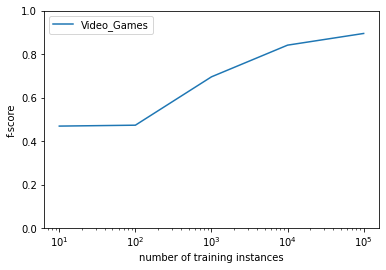

In [9]:
def run_tests_max_size(train,test,max_sizes):
    '''given a train and test set of reviews, evaluate against the test data when trying train_sizes equal to 
    each sizes in max_sizes, printing the macro f1'''
    #your code here
    
    #your code here
    return ...



max_sizes = [10,100,1000,10000,100000]

#your code here
legend = ["Video Games","Beauty", "Cell_Phones_and_Accessories"]    # note: I'm showing only Video Grames; 
#your code here
plt.show()

### Exercise 2: SVM Ranking

In this exercise, you will compare SVM regression to SVM ranking for predicting fine-grained opinion ratings.

#### 2.1
rubric={accuracy:2,quality:1}

First, do the regression version. Relative to what you did in exercise 1, there are three changes

- adapt the `prepare_for_classification` and `prepare_for_vectorizer` functions from 1.2 to a `prepare_for_regression` and `prepare_for_vectorizer_regression` functions which no longer convert the data into a binary label.
- change the SVC (support vector classifier) to a SVR (support vector regressor)
- evaluate the predicted ranks against the original ranks using Kendall's Tau (**to measure the degree of similarity between two rankings**), not f-score

As usual, run it for all three datasets.

In [10]:
def prepare_for_vectorizer_regression(reviews):
    '''given a list of review dictionaries, convert them to a list of texts and
    a list of rating scores in preparation for training a regression model'''
    #your code here
    scores = []         # no pos/neg; use "overall" as it is; 
    texts = []
    # otherwise, copy and paste from 1.2    

    return texts,scores

def prepare_for_regression(train,test,max_n=2):
    '''convert lists of reviews train and test to spare feature matrices X_train and X_test,
    and lists of ratings scores for train_class and test_class'''
    #your code here
    # copy and paste from 1.2 except for `prepare_for_vectorizer_regression`

    return X_train,train_scores, X_test,test_scores

In [9]:
for review_filename in     ["reviews_Musical_Instruments_5.json.gz"]: #
# ["reviews_Video_Games_5.json.gz","reviews_Beauty_5.json.gz","reviews_Cell_Phones_and_Accessories_5.json.gz"]:

    print(review_filename)
    train, test = load_amazon_reviews_no_dups(amazon_review_dir + review_filename) 
    train_features,train_scores, test_features,test_scores = prepare_for_regression(train,test)
    print("Training...")
    clf = LinearSVR()
    clf.fit(train_features,train_scores)
    print("Done training...")
    y_pred = clf.predict(test_features)
    print(kendalltau(y_pred,test_scores))

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html

# For Musical_Instruments_5:
# KendalltauResult(correlation=0.11345904958834789, pvalue=1.0091948560881858e-10) 
# 0.11 indicates between a weak and  medium associations;
# P-value <= 0.05: reject the null hypothesis
# P-value >  0.05: fail to reject the null hypothesis because there is not enough evidence; 
 

#### 2.2
rubric={accuracy:3,efficiency:1}

Now, you will implement SVMrank using LinearSVC.  The idea behind SVM ranking is that instead of simply predicting a score for a document, the SVM learns **from pairs of reviews**, and whether the rating of the first review is greater than that of the second.  
The key is to subtract one review from another: if we have feature vectors for two reviews, [0,1,1,0,0] and [1,0,0,1,1], and scores (1,4), then our pairwise feature vector is [-1,1,1,-1,-1], and the pairwise score is (0) (we subtract, just like with with the features, but we just want to know if it is > 0.  If it is, then the score is (1); otherwise, it is (0)).


```
[0,1,1,0,0], 1   <-- current datapoint and label
.
.
.
[1,0,0,1,1], 4  <-- randomly selected datapoint and label


=> [0,1,1,0,0] - [1,0,0,1,1], 1 - 4 = [-1,1,1,-1,-1], 0 <-- 0 if label is not greater than 0. 
```

The main part is to write a function `convert_to_pairwise` which converts the normal output of `prepare_for_regression` and turns it into a (pairwise) classification task using the following logic:

- for each original datapoint (feature vector), randomly select one other datapoint that has a different rating (you should keep trying until you get one, don't discard data!)
- create a feature vector which is the **difference between the two feature vectors** (subtract)
- create a label which should be 1 if the rating of the first datapoint is larger than the second, or 0 if the second rating is larger

You should return a new feature matrix (of the same length as the original data) and the corresponding list of labels. Note that you MUST preserve the sparsity of the feature matrix, these matrices are far too big to be densified.

This will take a while for the 100k datapoints you have in each corpus, and so you should have a counter that shows your progress.

In [12]:
def convert_to_pairwise(data,ratings): #convert_to_pairwise(train_features,train_scores)
    '''covert a normal collection of data with ordinal ratings into a pairwise classification task
    by randomly choosing one comparison datapoint with a different rating and taking the direction of
    the difference as the class of the new datapoint'''
    # your code here
    new_data = []
    pairwise_classes = []
    for 0..6100:                            # -> NOTE: not a python code 
        
        while find_a_random_data_point:     # -> NOTE: not a python code
            # find a data point where ratings are different:
            # if so, append it to new_data
            # new_rating (`pairwise_classes`)   1 if ratings[i] > ratings[j]: 
            #                                   0 if ratings[i] < ratings[j]: 



    return new_data, pairwise_classes 

# NOTE: new_data should be data - new_data; 
# if you do `data - new_data` for each data point, it will take a lot of time (we don't want it); 
# do at the end before `return` (or during `return`)

# it says "Note that you MUST preserve the sparsity of the feature matrix..."
# SOLUTION: use `vstack` (of sparse, it is NOT numpy `vstack`) for new_data to calcuate `data - new_data`
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.vstack.htmll
# >>> A = coo_matrix([[1, 2], [3, 4]])
# >>> B = coo_matrix([[5, 6]])
# >>> vstack([A, B]).toarray()
# array([[1, 2],
#        [3, 4],
#        [5, 6]])

```
print(train_features.shape):  (6100, 62003)
print(len(train_scores)):     6100
print(train_features[0]):
  (0, 16219)	1
  (0, 58112)	1
  (0, 23793)	1
  (0, 33837)	1
  (0, 40509)	1
  (0, 39120)	1
  (0, 9033)	1
  (0, 28212)	1
  (0, 53984)	1
  (0, 38973)	1
  (0, 35722)	1
  (0, 23927)	1
  (0, 59593)	1
  (0, 26865)	1
  (0, 18236)	1
  (0, 19338)	1
  (0, 3049)	1
  (0, 53012)	1
  (0, 46165)	1
  (0, 20614)	1
  (0, 23799)	1
  (0, 34085)	1
  (0, 39124)	1
  (0, 9169)	1
  (0, 28384)	1
  (0, 54513)	1
  (0, 39038)	1
  (0, 35733)	1
  (0, 24320)	1
  (0, 59618)	1
  (0, 26929)	1
  (0, 18441)	1
  (0, 19340)	1
  (0, 4202)	1
  (0, 53343)	1
  (0, 46241)	1
```

In [13]:
train, test = load_amazon_reviews_no_dups(amazon_review_dir + "reviews_Musical_Instruments_5.json.gz",test_size=200) 
train_features,train_scores, test_features,test_scores = prepare_for_regression(train,test)
pairwise_data, pairwise_class = convert_to_pairwise(train_features,train_scores)
assert pairwise_data.shape == train_features.shape
assert len(set(pairwise_class)) == 2
print("Success!")

all_reviews = 10261
train_set = 6100 test_set = 200
Success!


In [14]:
pairwise_data

<6100x62003 sparse matrix of type '<class 'numpy.int64'>'
	with 1446303 stored elements in Compressed Sparse Row format>

#### 2.3
rubric={accuracy:2}

Use `convert to pairwise` to carry out SVM ranking. Note that although you are converting the training set to pairwise, you don't do this for the test set.  (This takes advantage of a neat trick with SVMs where the training step just learns to assign high weights to binary features that occur in high scores, but not low ones.) 
Note also that you can't use the `predict` function for the resulting classifier because the result would be a class (ie, 1 or 0, but we want a value between 1 and 5). 
Instead, you want the result from taking **a dot product of each feature vector and the weights of the SVM classifier (`coef_[0]`)**. Again, evaluate the performance in the 3 corpora using Kendall's tau. You should get strikingly better results as compared to 2.1.  For example, on the Musical Instruments set, I get about 0.11 in 2.1, and 0.22 here.  The p-value is also significantly smaller.

In [15]:
for review_filename in ["reviews_Musical_Instruments_5.json.gz"]: #["reviews_Video_Games_5.json.gz","reviews_Beauty_5.json.gz","reviews_Cell_Phones_and_Accessories_5.json.gz"]:
    print(review_filename)
    #     1. load_amazon_reviews_no_dups() 
    #     2. prepare_for_regression()
    #     3. clf = LinearSVC()
    #     4. convert_to_pairwise()
    #     5. clf.fit()
    #     6. y_pred = test_features.dot(clf.coef_[0])
    #     print(kendalltau(y_pred,test_scores))
    

reviews_Musical_Instruments_5.json.gz
all_reviews = 10261
train_set = 237 test_set = 2000
KendalltauResult(correlation=0.22420763481123385, pvalue=2.2132732590854616e-37)


/Users/jungyeul/Library/Python/3.8/lib/python/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [16]:
y_pred

array([-0.35431007,  0.27601938, -0.21696982, ..., -1.22907758,
        0.27391499,  0.50317194])

### Exercise 3: Pollyannas and Negative Nellies
rubric={accuracy:3,quality:1}

https://en.wikipedia.org/wiki/Pollyanna


In this exercise, we are going to see how well our automated system is able to duplicate the conclusions of a simple kind of "author profiling" based on gold standard ratings. Two functions are provided to you: the first is `load_amazon_reviews_reviewer_groups` (a variation on `load_amazon_reviews_no_dups`) which creates a test set consisting of reviews written by authors with a total of at least 20 reviews; the training set consists of all other reviews.

The second function uses the test set to derive a list of "Pollyannas" and "Negative Nellies". The former is defined as reviewers who have only given five star reviews, and the latter are those reviewers whose average review rating is below 3 (True Negative Nellies, those who only give 1 star reviews, do not seem to exist! The Pollyanna hypothesis at work yet again...).

In [1]:
#provided code
review_min = 20

def load_amazon_reviews_reviewer_groups(corpus_path,test_size=2000,seed=42):
    '''loads a gzipped amazon review corpus and prepares a test set consisting of reviews whose reviewers
    has at least 20 total reviews, and the training set consisting of all other reviews'''
    g = gzip.open(corpus_path, 'r')
    all_reviews = [eval(line) for line in g]
    random.seed(seed)
    random.shuffle(all_reviews)
    train_set = []
    test_set = []
    reviewer_groups = defaultdict(list)
    for i,review in enumerate(all_reviews):
        reviewer_groups[review["reviewerID"]].append(review)
    for reviewer_group in reviewer_groups.values():
        if len(reviewer_group) > review_min:
            for review in reviewer_group:
                test_set.append(review)
        else:
            train_set.extend(reviewer_group)
        
    return train_set,test_set


def get_pollyannas_and_nellies(reviews):
    '''get a list of pollyannas (reviewers with only 5 star reviews) and negative nellies (those
    whose average rating is negative) based on the list of reviews'''
    reviewer_ratings = defaultdict(list)
    nellies = set()
    pollyannas = set()
    for review in reviews:
        reviewer_ratings[review["reviewerID"]].append(review["overall"])
    for reviewer,ratings in reviewer_ratings.items():
        avg = sum(ratings)/len(ratings)
        if avg < 3:
            nellies.add(reviewer)
        if avg == 5:
            pollyannas.add(reviewer)
    return pollyannas,nellies


Use the SVM ranking approach from exercise 2 to derive automatic ratings to the reviews for all reviewers with at least 20 reviews (i.e. the test set provided by `load_amazon_reviews_reviewer_groups`).  Train on the train set you just developed. 

Then use these ratings to rank the reviewers by the average positivity of their reviews, and see what percentage of the gold standard "Nellies" (as identified by `get_pollyannas_and_nellies`) are in the bottom 20% in terms of (automatically-determined) average positivity, and what percentage of gold standard "Pollyannas" are in the top 20%.

A high score indicates that we are more or less able to re-identify reviewers with strongly positive and negative biases using only automatically-generated review scores. Across the 3 review types, you will do consistently well on one of the types, and noticeably worse on the other (can you guess why?).  Also note that you may run into some issues evaluating on the small dataset this time - there's just too little data; there are no reviewers with 20 reviews that are either all '5's, or all < 3.

**Running the code takes time...**

In [ ]:
for review_filename in ["reviews_Video_Games_5.json.gz"]:
    #["reviews_Video_Games_5.json.gz","reviews_Beauty_5.json.gz","reviews_Cell_Phones_and_Accessories_5.json.gz"]:
    print(review_filename)
    
    # prepare the predications:
    # use load_amazon_reviews_reviewer_groups() instead of load_amazon_reviews_no_dups() as in Ex2.3. 
    # otherwise, it will be exactly same as in Ex2.3. 
    #     1. load_amazon_reviews_reviewer_groups()  
    #     2. prepare_for_regression()
    #     3. clf = LinearSVC()
    #     4. convert_to_pairwise()
    #     5. clf.fit()
    #     6. y_pred = test_features.dot(clf.coef_[0]) 

    
    # rank the reviewers by average predictions
    
    # test to see if pollyannas/nellies are in top/bottom 20%

reviews_Video_Games_5.json.gz
